# **Assignment Roadmap**

This assignment asks you to build a complete Brain-Computer Interface (BCI) pipeline. Your goal is to take raw, noisy electrical brain signals and turn them into a clear Yes/No decision: Is this the character the user wants?

**Theres not much theory to learn other than implementation, you have to learn this by doing**

## AI Usage Policy for This Assignment

You're welcome to use AI for this assignment. Given the complexity of EEG signal processing and machine learning,
We don't expect you to know every implementation detail from scratch and neither does any recuiter or any professor.


Use AI to:

    Debug errors and troubleshoot issues

    Understand concepts and explore different approaches

What matters:

    You understand your code and can explain how it works

    You learn from the process, not just copy-paste

### **1: Cleaning the Signal (Preprocessing)**

The Goal: Raw EEG data is full of "garbage" frequencies like muscle movement and electrical hum. You need to filter the data to keep only the brain waves relevant to the P300 response (typically 0.1Hz – 20Hz).

You have already done this in the previous assignment but this one is a more standard procedure.

Common Pitfalls:

    Filter Lag: Standard filters can delay the signal, meaning the brain response looks like it happened later than it actually did. To prevent this, use zero-phase filtering (e.g., scipy.signal.filtfilt) instead of standard filtering (lfilter).

    Aliasing: You are asked to downsample the data from 240Hz to 60Hz to make it faster to process. Do not simply slice the array (e.g., data[::4]) without filtering first. If you do, high-frequency noise will "fold over" into your low frequencies and corrupt the data. Always filter before downsampling.

### **2: Epoch Extraction**

The Goal: You need to convert the continuous stream of data into specific "events" or "epochs."

The Concept: A P300 response happens roughly 300ms after a flash. Your code needs to identify every moment a flash occurs (stimulus_onset), look forward in time (e.g., 800ms), and "snip" that window of data out.

Visualizing the Data Structure:

    Input: A continuous 2D matrix (Total_Time_Points, 64_Channels)

    Output: A 3D block of events (Number_of_Flashes, Time_Points_Per_Window, 64_Channels)

Common Pitfall:

    Indexing Errors: This dataset may originate from MATLAB (which uses 1-based indexing), while Python uses 0-based indexing. If your index calculation is off by even one sample, your window will shift, and the machine learning model will be training on random noise rather than the brain response. Double-check your start and end indices.

### **3: Making Data "Model-Ready" (Feature Engineering)**

The Goal: Standard Machine Learning models (like SVM or LDA) cannot understand 3D arrays. They generally require a 2D matrix (like an Excel sheet). The Task:

    Time Domain: You will need to "flatten" the epochs. If an epoch is 60 time points × 64 channels, it becomes a single flat row of 3,840 numbers.

    PCA/CSP: These are compression techniques. The goal is to reduce those 3,840 numbers down to perhaps 20 numbers that capture the most important information.

Common Pitfall:

    Data Leakage: When using PCA or CSP, you must be careful not to "cheat." You should .fit() your reducer only on the training data, and then .transform() the test data. If you fit on the combined dataset, your model "sees" the test answers ahead of time, leading to artificially high scores that won't work in the real world.

### **4: Classification**

The Goal: Feed your features into the ML models (LDA, SVM, etc.) provided in the skeleton code to classify "Target" vs. "Non-Target" flashes.

Common Pitfall:

    Class Imbalance: In a P300 speller, the letter the user wants (Target) only flashes 1 out of 6 times. The other 5 flashes are Non-Targets.

        If your model decides to simply guess "Non-Target" every single time, it will still achieve ~83% accuracy. This is a useless model.

        Do not rely solely on Accuracy. Check the F1-Score or the Confusion Matrix. A good model must be able to correctly identify the rare Target events, not just the frequent Non-Targets.

In [1]:
# The assignment is structured in a way that its modular so thats its easier to debug whats wrong

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import butter, filtfilt, iirnotch
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import pickle
import json
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import scipy.io as sio
################################################################################
# SECTION 1: DATA LOADING AND BASIC SETUP
################################################################################

# Character matrix (6x6) for P300 speller
CHAR_MATRIX = np.array([
    ['A', 'B', 'C', 'D', 'E', 'F'],
    ['G', 'H', 'I', 'J', 'K', 'L'],
    ['M', 'N', 'O', 'P', 'Q', 'R'],
    ['S', 'T', 'U', 'V', 'W', 'X'],
    ['Y', 'Z', '1', '2', '3', '4'],
    ['5', '6', '7', '8', '9', '_']
])

def load_data(file_path):
    """
    Load P300 BCI Competition III data
    Returns dictionary with signal, flashing, stimulus_code, stimulus_type, target_char
    """
    try:
        data = sio.loadmat(file_path)

        # Different dataset structures might have different keys
        # Try common key names
        if 'Signal' in data:
            signal_key = 'Signal'
        elif 'signal' in data:
            signal_key = 'signal'
        elif 'X' in data:
            signal_key = 'X'
        else:
            # Try to find any 3D or 2D array that looks like EEG
            for key in data.keys():
                if not key.startswith('__') and isinstance(data[key], np.ndarray):
                    if len(data[key].shape) == 2 and data[key].shape[1] > 8:  # Likely EEG channels
                        signal_key = key
                        break
            else:
                signal_key = list(data.keys())[3]  # Fallback

        result = {
            'signal': data[signal_key],
            'flashing': data['Flashing'] if 'Flashing' in data else data['flashing'],
            'stimulus_code': data['StimulusCode'] if 'StimulusCode' in data else data['stimulus_code'],
            'stimulus_type': data['StimulusType'] if 'StimulusType' in data else None,
            'target_char': data['TargetChar'] if 'TargetChar' in data else None
        }

        print(f"  Loaded {file_path}")
        print(f"  Signal shape: {result['signal'].shape}")
        print(f"  Flashing shape: {result['flashing'].shape}")

        return result

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        # Return mock data for testing
        print("  Returning mock data for testing...")
        n_samples = 10000
        n_channels = 64
        return {
            'signal': np.random.randn(n_samples, n_channels),
            'flashing': np.random.randint(0, 2, (n_samples, 1)),
            'stimulus_code': np.random.randint(1, 13, (n_samples, 1)),
            'stimulus_type': np.random.randint(0, 2, (n_samples, 1)),
            'target_char': np.array(['A'])
        }



    # Training data has labels, test data doesn't


def get_char_from_codes(row_code, col_code):
    """
    Convert row/column stimulus codes to character
    """

    if 1 <= row_code <= 6:
        row = row_code - 1
        return CHAR_MATRIX[row, :]
    elif 7 <= col_code <= 12:
        col = col_code - 7
        return CHAR_MATRIX[:, col]
    return None

In [3]:
################################################################################
# SECTION 2: EEG SIGNAL ACQUISITION & PREPROCESSING
################################################################################

def bandpass_filter(signal, lowcut=0.1, highcut=20, fs=240, order=5):
    """
    Apply band-pass filter to remove low-frequency drift and high-frequency noise
    Typical P300 band: 0.1-20 Hz
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    # Design Butterworth filter
    b, a = butter(order, [low, high], btype='band')

    # Apply zero-phase filtering
    filtered_signal = filtfilt(b, a, signal, axis=0)

    return filtered_signal


def notch_filter(signal, freq=50, fs=240, Q=30):
    """
    Remove powerline interference (50/60 Hz)
    """
    w0 = freq / (fs / 2)
    b, a = iirnotch(w0, Q)

    # Apply zero-phase filtering
    filtered_signal = filtfilt(b, a, signal, axis=0)

    return filtered_signal


def baseline_correction(epoch, baseline_samples=50):
    """
    Apply baseline correction by subtracting pre-stimulus baseline
    """
    if len(epoch.shape) == 2:  # Single epoch
        baseline = np.mean(epoch[:baseline_samples, :], axis=0)
        corrected = epoch - baseline
    else:  # Multiple epochs
        baseline = np.mean(epoch[:, :baseline_samples, :], axis=1, keepdims=True)
        corrected = epoch - baseline

    return corrected


def downsample_signal(signal, original_fs=240, target_fs=60):
    """
    Downsample signal to reduce computational load
    240 Hz -> 60 Hz reduces data by 4x
    """
    if original_fs == target_fs:
        return signal

    factor = original_fs // target_fs

    # Apply anti-aliasing filter before downsampling
    from scipy.signal import decimate
    downsampled = decimate(signal, factor, axis=0, ftype='fir')

    return downsampled


def artifact_rejection(signal, threshold=100):
    """
    Simple artifact rejection based on amplitude threshold
    More advanced: use ICA or wavelet denoising
    """
    amplitude_range = np.ptp(signal, axis=0)

    # Find channels with excessive amplitude
    bad_channels = amplitude_range > threshold

    if np.any(bad_channels):
        print(f"  Found {np.sum(bad_channels)} channels with artifacts")
        # Option 1: Interpolate bad channels
        # Option 2: Replace with zeros or nan
        signal[:, bad_channels] = 0

    return signal


def preprocess_pipeline(data, apply_bandpass=True, apply_notch=True,
                       apply_downsample=True, fs=240):
    """
    Complete preprocessing pipeline:
    1. Reshape 3D signal (repetitions, time, channels) to 2D (total_time, channels)
    2. Bandpass filtering (0.1-20 Hz)
    3. Notch filtering (50 Hz)
    4. Downsampling (240->60 Hz)
    """
    print("  Starting preprocessing...")
    original_signal = data['signal'].copy()

    # Explicitly cast to float64 and handle NaNs right at the start
    original_signal = original_signal.astype(np.float64)
    print(f"  NaNs in original_signal before initial nan_to_num: {np.sum(np.isnan(original_signal))}")
    original_signal = np.nan_to_num(original_signal, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"  NaNs in original_signal after initial forced cleanup: {np.sum(np.isnan(original_signal))}")

    original_flashing = data['flashing'].copy()
    original_stim_code = data['stimulus_code'].copy()
    original_stim_type = data['stimulus_type'].copy() if data['stimulus_type'] is not None else None

    # Reshape 3D data to 2D continuous stream
    # Ensure signal is 3D (repetitions, time, channels)
    if original_signal.ndim == 3:
        n_repetitions, n_time_points_per_repetition, n_channels = original_signal.shape
        signal_2d = original_signal.reshape(-1, n_channels)
        flashing_1d = original_flashing.reshape(-1)
        stim_code_1d = original_stim_code.reshape(-1)
        if original_stim_type is not None:
            stim_type_1d = original_stim_type.reshape(-1)
        else:
            stim_type_1d = None # Keep it None if it was originally None
        print(f"  Reshaped 3D signal to 2D: {signal_2d.shape}")
    elif original_signal.ndim == 2:
        signal_2d = original_signal
        flashing_1d = original_flashing.flatten()
        stim_code_1d = original_stim_code.flatten()
        stim_type_1d = original_stim_type.flatten() if original_stim_type is not None else None
        print(f"  Signal is already 2D: {signal_2d.shape}")
    else:
        raise ValueError("Signal dimension not supported. Expected 2D or 3D.")

    processed_signal = signal_2d
    print(f"  NaNs in signal_2d after reshape: {np.sum(np.isnan(processed_signal))}")

    # Step 1: Bandpass filter
    if apply_bandpass:
        print("  Applying bandpass filter (0.1-20 Hz)...")
        processed_signal = bandpass_filter(processed_signal, lowcut=0.1, highcut=20, fs=fs, order=5)
        processed_signal = np.nan_to_num(processed_signal, nan=0.0, posinf=0.0, neginf=0.0) # Re-clean after filtering
        print(f"  NaNs after bandpass filter: {np.sum(np.isnan(processed_signal))}")

    # Step 2: Notch filter
    if apply_notch:
        print("  Applying notch filter (50 Hz)...")
        processed_signal = notch_filter(processed_signal, freq=50, fs=fs, Q=30)
        processed_signal = np.nan_to_num(processed_signal, nan=0.0, posinf=0.0, neginf=0.0) # Re-clean after filtering
        print(f"  NaNs after notch filter: {np.sum(np.isnan(processed_signal))}")

    # Step 3: Artifact rejection
    print("  Applying artifact rejection...")
    processed_signal = artifact_rejection(processed_signal, threshold=100)
    processed_signal = np.nan_to_num(processed_signal, nan=0.0, posinf=0.0, neginf=0.0) # Re-clean after artifact rejection
    print(f"  NaNs after artifact rejection: {np.sum(np.isnan(processed_signal))}")

    # Step 4: Downsampling
    new_fs = fs
    if apply_downsample and fs == 240: # Assuming original fs is always 240 here as per assignment
        print("  Downsampling from 240Hz to 60Hz...")
        processed_signal = downsample_signal(processed_signal, original_fs=240, target_fs=60)
        processed_signal = np.nan_to_num(processed_signal, nan=0.0, posinf=0.0, neginf=0.0) # Re-clean after downsampling
        print(f"  NaNs after downsampling: {np.sum(np.isnan(processed_signal))}")
        # Downsample flashing, stimulus_code, stimulus_type as well
        factor = 240 // 60
        flashing_1d = flashing_1d[::factor]
        stim_code_1d = stim_code_1d[::factor]
        if stim_type_1d is not None:
            stim_type_1d = stim_type_1d[::factor]
        new_fs = 60


    print(f"  Preprocessing complete. New shape: {processed_signal.shape}, New fs: {new_fs}Hz")
    # Final check and cleanup before returning
    processed_signal = np.nan_to_num(processed_signal, nan=0.0, posinf=0.0, neginf=0.0)
    print(f"  Final NaNs in processed_signal before return: {np.sum(np.isnan(processed_signal))}")

    processed_data = {
        'signal': processed_signal,
        'flashing': flashing_1d,
        'stimulus_code': stim_code_1d,
        'stimulus_type': stim_type_1d,
        'target_char': data['target_char'], # Target char is usually per run, not per sample
        'fs': new_fs
    }

    return processed_data


def extract_epochs(data, epoch_length_ms=800, fs=60):
    """
    Extract epochs around stimulus onset
    - Event tagging: Use flashing signal to detect stimulus onset
    - Stimulus alignment: Extract fixed-length windows after each flash
    - Epoch extraction: Collect all stimulus-locked epochs

    Returns: Dictionary with epochs, labels, codes, character indices
    """
    print("  Extracting epochs...")

    signal = data['signal']
    flashing = data['flashing'].flatten()
    stimulus_code = data['stimulus_code'].flatten()

    # Check if we have labels
    if data['stimulus_type'] is not None:
        stimulus_type = data['stimulus_type'].flatten()
    else:
        # For test data, create dummy labels
        stimulus_type = np.zeros_like(stimulus_code)

    # Calculate epoch length in samples
    epoch_samples = int(epoch_length_ms / 1000 * fs)

    # Find stimulus onsets (flashing goes from 0 to 1)
    diff_flashing = np.diff(flashing)
    onset_indices = np.where(diff_flashing == 1)[0] + 1  # +1 because diff reduces index

    print(f"  Found {len(onset_indices)} stimulus onsets")

    # Initialize lists
    epochs = []
    labels = []
    codes_list = []
    char_idx_list = []

    # Extract epochs
    for i, idx in enumerate(onset_indices):
        if i < 5 or i > len(onset_indices) - 5: # Print for first/last few onsets
            print(f"  Debug: idx={idx}, epoch_samples={epoch_samples}, len(signal)={len(signal)}, condition: {idx + epoch_samples <= len(signal)}")
        # Check if we have enough samples after onset
        if idx + epoch_samples <= len(signal):
            # Extract epoch
            epoch = signal[idx:idx + epoch_samples, :]

            # Apply baseline correction
            if epoch.shape[0] > 50:
                epoch = baseline_correction(epoch, baseline_samples=min(50, epoch.shape[0]))

            epochs.append(epoch)

            # Get stimulus code and type at onset
            code = stimulus_code[idx]
            label = stimulus_type[idx] if idx < len(stimulus_type) else 0

            labels.append(label)
            codes_list.append(code)

            # Convert code to character index
            if 1 <= code <= 6:  # Row
                char_idx_list.append(code - 1)
            elif 7 <= code <= 12:  # Column
                char_idx_list.append(code - 7)
            else:
                char_idx_list.append(-1)

    # Convert to numpy arrays
    epochs = np.array(epochs)
    labels = np.array(labels)

    print(f"  Extracted {len(epochs)} epochs with shape {epochs.shape}")
    print(f"  Class distribution: Target={np.sum(labels==1)}, Non-target={np.sum(labels==0)}")

    return {
        'epochs': epochs,
        'labels': labels,
        'codes': np.array(codes_list),
        'char_indices': np.array(char_idx_list)
    }

    return {
        'epochs': epochs,
        'labels': labels,
        'codes': np.array(codes_list),
        'char_indices': np.array(char_idx_list)
    }

def plot_erp_responses(epoch_data, channel_idx=31, fs=60):
    """
    Visualize ERP responses and confirm P300 peaks around 300ms
    Channel 31 = Cz (central midline electrode, best for P300)
    """
    epochs = epoch_data['epochs']
    labels = epoch_data['labels']

    # Separate target and non-target epochs
    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]

    if len(target_epochs) == 0 or len(non_target_epochs) == 0:
        print("  Not enough data for ERP visualization")
        return

    # Calculate mean ERPs
    mean_target = np.mean(target_epochs[:, :, channel_idx], axis=0)
    mean_nontarget = np.mean(non_target_epochs[:, :, channel_idx], axis=0)

    # Calculate standard error
    se_target = np.std(target_epochs[:, :, channel_idx], axis=0) / np.sqrt(len(target_epochs))
    se_nontarget = np.std(non_target_epochs[:, :, channel_idx], axis=0) / np.sqrt(len(non_target_epochs))

    # Create time axis
    time_ms = np.arange(len(mean_target)) * (1000 / fs)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot averages with standard error
    ax1.plot(time_ms, mean_target, 'r-', linewidth=2, label='Target')
    ax1.fill_between(time_ms, mean_target - se_target, mean_target + se_target,
                     alpha=0.3, color='red')

    ax1.plot(time_ms, mean_nontarget, 'b-', linewidth=2, label='Non-target')
    ax1.fill_between(time_ms, mean_nontarget - se_nontarget, mean_nontarget + se_nontarget,
                     alpha=0.3, color='blue')

    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Amplitude (μV)')
    ax1.set_title(f'ERP Responses at Channel {channel_idx} (Cz)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Mark P300 peak region
    p300_start = 250  # ms
    p300_end = 400    # ms
    p300_samples = np.where((time_ms >= p300_start) & (time_ms <= p300_end))[0]

    if len(p300_samples) > 0:
        ax1.axvspan(p300_start, p300_end, alpha=0.2, color='yellow', label='P300 region')
        ax1.legend()

    # Plot difference wave
    difference = mean_target - mean_nontarget
    ax2.plot(time_ms, difference, 'g-', linewidth=2, label='Target - Non-target')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Amplitude Difference (μV)')
    ax2.set_title('Difference Wave (P300 Effect)')
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax2.axvspan(p300_start, p300_end, alpha=0.2, color='yellow', label='P300 region')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Calculate P300 amplitude difference
    if len(p300_samples) > 0:
        p300_amplitude = np.max(difference[p300_samples]) - np.min(difference[p300_samples])
        print(f"  P300 amplitude in {p300_start}-{p300_end}ms window: {p300_amplitude:.2f} μV")

    return fig



In [4]:
################################################################################
# SECTION 3: FEATURE ENGINEERING & BASELINE CLASSIFIERS
################################################################################

def extract_time_domain_features(epochs):
    """
    Extract time-domain features: simply flatten the epochs
    Shape: (n_epochs, n_samples * n_channels)
    """
    n_epochs = epochs.shape[0]
    n_features = epochs.shape[1] * epochs.shape[2]

    features = epochs.reshape(n_epochs, n_features)

    print(f"  Time-domain features: {features.shape}")
    return features

def extract_pca_features(epochs, n_components=20):
    """
    Extract PCA features for dimensionality reduction
    Reduces (n_samples * n_channels) to n_components
    """
    # Flatten epochs first
    n_epochs = epochs.shape[0]
    n_features = epochs.shape[1] * epochs.shape[2]

    X_flat = epochs.reshape(n_epochs, n_features)

    # Robust NaN handling
    X_flat = np.nan_to_num(X_flat, nan=0.0)

    # Check for constant features
    std_dev = np.std(X_flat, axis=0)
    constant_features = np.where(std_dev < 1e-10)[0]
    if len(constant_features) > 0:
        print(f"  Warning: {len(constant_features)} constant features found")
        # Add small noise to constant features
        X_flat[:, constant_features] += np.random.normal(0, 1e-6, (n_epochs, len(constant_features)))

    # Apply PCA with robust settings
    try:
        pca = PCA(n_components=min(n_components, X_flat.shape[1]-1))
        X_pca = pca.fit_transform(X_flat)

        print(f"  PCA features: {X_pca.shape}")
        if hasattr(pca, 'explained_variance_ratio_'):
            explained_var = np.sum(pca.explained_variance_ratio_)
            if not np.isnan(explained_var):
                print(f"  Explained variance: {explained_var:.3f}")
            else:
                print(f"  Explained variance: Could not compute (data may be degenerate)")

        return X_pca, pca
    except Exception as e:
        print(f"  PCA failed: {e}")
        # Return time-domain features as fallback
        return X_flat, None

def extract_csp_features(epochs, labels, n_components=6):
    """
    Common Spatial Patterns (CSP) for discriminative spatial filters
    Finds spatial filters that maximize variance ratio between classes
    """
    target_epochs = epochs[labels == 1]
    non_target_epochs = epochs[labels == 0]
    print(f"  Target epochs for CSP: {len(target_epochs)}")
    print(f"  Non-target epochs for CSP: {len(non_target_epochs)}")

    if len(target_epochs) < 2 or len(non_target_epochs) < 2:
        print("  Not enough data for CSP. Returning PCA instead.")
        return extract_pca_features(epochs, n_components=n_components)

    # Add regularization to prevent singular matrices
    reg_coef = 0.01

    # Compute covariance matrices with regularization
    def compute_cov(data):
        n_trials = data.shape[0]
        covs = []
        for trial in range(n_trials):
            X = data[trial]
            # Handle NaN values
            X = np.nan_to_num(X, nan=0.0)
            cov = np.dot(X.T, X) / np.trace(np.dot(X.T, X))
            # Add regularization
            cov += reg_coef * np.eye(cov.shape[0])
            covs.append(cov)
        return np.mean(covs, axis=0)

    try:
        cov_target = compute_cov(target_epochs)
        cov_nontarget = compute_cov(non_target_epochs)

        # Solve generalized eigenvalue problem with regularization
        eigenvalues, eigenvectors = eigh(cov_target, cov_target + cov_nontarget)

        # Sort by eigenvalues (descending)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Select most discriminative components (extreme eigenvalues)
        n_filters = min(n_components, len(eigenvalues))
        filters = eigenvectors[:, :n_filters//2]
        filters = np.hstack([filters, eigenvectors[:, -n_filters//2:]])

        # Extract CSP features (log variance)
        features = []
        for i in range(len(epochs)):
            X = epochs[i]
            X = np.nan_to_num(X, nan=0.0)  # Handle NaN
            X_filtered = np.dot(X, filters)  # (n_samples, n_filters)
            var = np.var(X_filtered, axis=0)  # variance per filter
            var = np.log(var + 1e-10)  # log variance
            features.append(var)

        features = np.array(features)

        print(f"  CSP features: {features.shape}")
        return features, filters

    except Exception as e:
        print(f"  CSP failed: {e}")
        print("  Falling back to PCA features")
        return extract_pca_features(epochs, n_components=n_components)


def extract_features(epoch_data, method='pca', n_components=20):
    """
    Feature extraction wrapper supporting multiple methods:
    - time_domain: Raw time-domain samples (flattened)
    - pca: Principal Component Analysis
    - csp: Common Spatial Patterns
    """
    epochs = epoch_data['epochs']
    labels = epoch_data['labels'] if 'labels' in epoch_data else None

    print(f"  Extracting features using {method.upper()}...")

    if method == 'time_domain' or method == 'time':
        features = extract_time_domain_features(epochs)
        return features, None

    elif method == 'pca':
        features, transformer = extract_pca_features(epochs, n_components=n_components)
        return features, transformer

    elif method == 'csp':
        if labels is None:
            print("  CSP requires labels. Using PCA instead.")
            return extract_features(epoch_data, method='pca', n_components=n_components)
        features, transformer = extract_csp_features(epochs, labels, n_components=n_components)
        return features, transformer

    else:
        raise ValueError(f"Unknown method: {method}")

class CSPTransformer:
    """
    Wrapper for CSP filters to enable transform() method
    """
    def __init__(self, filters):
        self.filters = filters

    def transform(self, epochs):
        features = []
        for i in range(len(epochs)):
            X = epochs[i]
            X_filtered = np.dot(X, self.filters)
            var = np.var(X_filtered, axis=0)
            var = np.log(var + 1e-10)
            features.append(var)
        return np.array(features)


def train_lda_classifier(X_train, y_train):
    """
    Linear Discriminant Analysis with balanced priors
    """
    print("  Training LDA classifier...")

    # Handle NaN values in training data
    X_train = np.nan_to_num(X_train, nan=0.0)

    # Check if we have enough samples and variance
    if len(np.unique(y_train)) < 2:
        print("    Error: Need at least 2 classes for LDA")
        return None

    # Handle class imbalance
    unique_classes = np.unique(y_train)
    if len(unique_classes) == 2:
        class_weights = {}
        for cls in unique_classes:
            class_weights[cls] = len(y_train) / (len(unique_classes) * np.sum(y_train == cls))

        try:
            lda = LinearDiscriminantAnalysis(
                priors=[class_weights.get(0, 0.5), class_weights.get(1, 0.5)],
                solver='svd',  # Use SVD solver which is more stable
                shrinkage=None,
                tol=1e-4
            )
            lda.fit(X_train, y_train)

            train_acc = lda.score(X_train, y_train)
            print(f"    Training accuracy: {train_acc:.4f}")
            return lda
        except Exception as e:
            print(f"    LDA failed: {e}")
            print("    Using simple mean classifier as fallback")
            # Fallback to a simple classifier
            from sklearn.dummy import DummyClassifier
            dummy = DummyClassifier(strategy='stratified')
            dummy.fit(X_train, y_train)
            return dummy
    else:
        print("    Only one class present, using dummy classifier")
        from sklearn.dummy import DummyClassifier
        dummy = DummyClassifier(strategy='most_frequent')
        dummy.fit(X_train, y_train)
        return dummy

def train_logistic_regression(X_train, y_train):
    """
    Logistic Regression - baseline classifier
    https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    """
    print("  Training Logistic Regression...")

    lr = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        solver='liblinear'
    )
    lr.fit(X_train, y_train)

    print(f"    Training accuracy: {lr.score(X_train, y_train):.4f}")
    return lr


def evaluate_classifier(model, X_test, y_test, model_name="Model"):
    """
    Comprehensive classifier evaluation
    """
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n  {model_name} Performance:")
    print(f"    Accuracy:  {accuracy:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall:    {recall:.4f}")
    print(f"    F1-score:  {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"    Confusion Matrix:")
    print(f"      [[TN {cm[0,0]:3d}  FP {cm[0,1]:3d}]]")
    print(f"       [FN {cm[1,0]:3d}  TP {cm[1,1]:3d}]]")

    # ROC-AUC if probabilities available
    if y_prob is not None and len(np.unique(y_test)) > 1:
        try:
            auc = roc_auc_score(y_test, y_prob)
            print(f"    ROC-AUC:   {auc:.4f}")
        except:
            pass

    return accuracy

In [5]:
################################################################################
# SECTION 4: CLASSICAL MACHINE LEARNING MODELS
################################################################################

def train_svm_classifier(X_train, y_train, kernel='rbf', C=1.0):
    """
    Support Vector Machine with RBF kernel
    Good for non-linear decision boundaries
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    """
    print(f"  Training SVM (kernel={kernel}, C={C})...")

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Train SVM with class weighting for imbalance
    svm = SVC(
        kernel=kernel,
        C=C,
        class_weight='balanced',
        probability=True,
        random_state=42,
        gamma='scale'
    )
    svm.fit(X_train_scaled, y_train)

    # Training accuracy
    train_acc = svm.score(X_train_scaled, y_train)
    print(f"    Training accuracy: {train_acc:.4f}")

    return svm, scaler


def train_random_forest(X_train, y_train, n_estimators=100):
    """
    Random Forest Classifier
    Ensemble method, robust to overfitting
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    """
    print(f"  Training Random Forest (n_estimators={n_estimators})...")

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    train_acc = rf.score(X_train, y_train)
    print(f"    Training accuracy: {train_acc:.4f}")

    return rf


def train_gradient_boosting(X_train, y_train, n_estimators=100):
    """
    Gradient Boosting Classifier with manual sample weighting
    (GradientBoosting doesn't support class_weight parameter)
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    """
    print(f"\n  Training Gradient Boosting (n_estimators={n_estimators})...")

    # Calculate sample weights manually
    n_samples = len(y_train)
    n_classes = len(np.unique(y_train))

    # Count samples per class
    class_counts = {}
    for cls in np.unique(y_train):
        class_counts[cls] = np.sum(y_train == cls)

    # Calculate weights
    sample_weights = np.ones(n_samples)
    for i, cls in enumerate(y_train):
        sample_weights[i] = n_samples / (n_classes * class_counts[cls])

    # Train Gradient Boosting
    gb = GradientBoostingClassifier(
        n_estimators=n_estimators,
        random_state=42,
        subsample=0.8
    )
    gb.fit(X_train, y_train, sample_weight=sample_weights)

    train_acc = gb.score(X_train, y_train)
    print(f"    Training accuracy: {train_acc:.4f}")

    return gb



def compare_all_classical_models(X_train, y_train, X_test, y_test):
    """
    Train and compare all classical ML models
    Returns performance comparison
    """
    print("  Comparing classical ML models...")

    results = {}
    models = {}

    # Calculate sample weights once for methods that need it
    n_samples = len(y_train)
    n_classes = len(np.unique(y_train))
    class_counts = {cls: np.sum(y_train == cls) for cls in np.unique(y_train)}
    sample_weights = np.ones(n_samples)
    for i, cls in enumerate(y_train):
        sample_weights[i] = n_samples / (n_classes * class_counts[cls])

    # Define models to train
    model_configs = [
        ('LDA', LinearDiscriminantAnalysis()),
        ('Logistic Regression', LogisticRegression(class_weight='balanced', random_state=42)),
        ('SVM', SVC(kernel='rbf', C=1.0, class_weight='balanced', probability=True, random_state=42)),
        ('Random Forest', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
        ('Gradient Boosting', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ]

    for name, model in model_configs:
        print(f"\n  --- Training {name} ---")

        # Training
        start_time = time.time()

        if name == 'Gradient Boosting':
            model.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            model.fit(X_train, y_train)

        training_time = time.time() - start_time

        # Inference
        start_time = time.time()
        y_pred = model.predict(X_test)
        inference_time = time.time() - start_time

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'training_time': training_time,
            'inference_time': inference_time
        }

        models[name] = model

        print(f"    Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        print(f"    Training time: {training_time:.2f}s, Inference time: {inference_time:.4f}s")

    # Summary table
    print("\n" + "="*70)
    print("MODEL COMPARISON SUMMARY")
    print("="*70)
    print(f"{'Model':<20} {'Accuracy':<10} {'F1-Score':<10} {'Train Time':<12} {'Inf Time':<10}")
    print("-"*70)

    for name, metrics in results.items():
        print(f"{name:<20} {metrics['accuracy']:<10.4f} {metrics['f1']:<10.4f} "
              f"{metrics['training_time']:<12.2f} {metrics['inference_time']:<10.4f}")

    return results, models



def save_model(model, filepath):
    """Save model to pickle file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"\n  Model saved to: {filepath}")

def load_model(filepath):
    """Load model from pickle file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    print(f"\n  Model loaded from: {filepath}")
    return model

In [6]:
    # ========================================================================
    # STEP 1: LOAD DATA
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 1: LOADING DATA")
    print("="*70)

    from google.colab import drive

    drive.mount('/content/drive')
    DATA_PATH = '/content/drive/MyDrive/EEG speller winter 25/'

    train_data_A = load_data(DATA_PATH + 'Subject_A_Train.mat')
    test_data_A = load_data(DATA_PATH + 'Subject_A_Test.mat')
    train_data_B = load_data(DATA_PATH + 'Subject_B_Train.mat')
    test_data_B = load_data(DATA_PATH + 'Subject_B_Test.mat')



STEP 1: LOADING DATA
Mounted at /content/drive
  Loaded /content/drive/MyDrive/EEG speller winter 25/Subject_A_Train.mat
  Signal shape: (85, 7794, 64)
  Flashing shape: (85, 7794)
  Loaded /content/drive/MyDrive/EEG speller winter 25/Subject_A_Test.mat
  Signal shape: (100, 7794, 64)
  Flashing shape: (100, 7794)
  Loaded /content/drive/MyDrive/EEG speller winter 25/Subject_B_Train.mat
  Signal shape: (85, 7794, 64)
  Flashing shape: (85, 7794)
  Loaded /content/drive/MyDrive/EEG speller winter 25/Subject_B_Test.mat
  Signal shape: (100, 7794, 64)
  Flashing shape: (100, 7794)


In [7]:
    # ========================================================================
    # STEP 2: PREPROCESSING
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 2: PREPROCESSING")
    print("="*70)

    print("\n--- Subject A ---")
    train_proc_A = preprocess_pipeline(train_data_A)
    test_proc_A = preprocess_pipeline(test_data_A)

    print("\n--- Subject B ---")
    train_proc_B = preprocess_pipeline(train_data_B)
    test_proc_B = preprocess_pipeline(test_data_B)



STEP 2: PREPROCESSING

--- Subject A ---
  Starting preprocessing...
  NaNs in original_signal before initial nan_to_num: 0
  NaNs in original_signal after initial forced cleanup: 0
  Reshaped 3D signal to 2D: (662490, 64)
  NaNs in signal_2d after reshape: 0
  Applying bandpass filter (0.1-20 Hz)...
  NaNs after bandpass filter: 0
  Applying notch filter (50 Hz)...
  NaNs after notch filter: 0
  Applying artifact rejection...
  NaNs after artifact rejection: 0
  Downsampling from 240Hz to 60Hz...
  NaNs after downsampling: 0
  Preprocessing complete. New shape: (165623, 64), New fs: 60Hz
  Final NaNs in processed_signal before return: 0
  Starting preprocessing...
  NaNs in original_signal before initial nan_to_num: 0
  NaNs in original_signal after initial forced cleanup: 0
  Reshaped 3D signal to 2D: (779400, 64)
  NaNs in signal_2d after reshape: 0
  Applying bandpass filter (0.1-20 Hz)...
  NaNs after bandpass filter: 0
  Applying notch filter (50 Hz)...
  NaNs after notch filter

In [8]:
    # ========================================================================
    # STEP 3: EPOCH EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 3: EPOCH EXTRACTION")
    print("="*70)

    print("\n--- Subject A ---")
    train_epochs_A = extract_epochs(train_proc_A)
    test_epochs_A = extract_epochs(test_proc_A)

    print("\n--- Subject B ---")
    train_epochs_B = extract_epochs(train_proc_B)
    test_epochs_B = extract_epochs(test_proc_B)


STEP 3: EPOCH EXTRACTION

--- Subject A ---
  Extracting epochs...
  Found 15299 stimulus onsets
  Debug: idx=11, epoch_samples=48, len(signal)=165623, condition: True
  Debug: idx=21, epoch_samples=48, len(signal)=165623, condition: True
  Debug: idx=32, epoch_samples=48, len(signal)=165623, condition: True
  Debug: idx=42, epoch_samples=48, len(signal)=165623, condition: True
  Debug: idx=53, epoch_samples=48, len(signal)=165623, condition: True
  Debug: idx=165522, epoch_samples=48, len(signal)=165623, condition: True
  Debug: idx=165533, epoch_samples=48, len(signal)=165623, condition: True
  Debug: idx=165543, epoch_samples=48, len(signal)=165623, condition: True
  Debug: idx=165554, epoch_samples=48, len(signal)=165623, condition: True
  Extracted 15299 epochs with shape (15299, 48, 64)
  Class distribution: Target=2550, Non-target=12749
  Extracting epochs...
  Found 17999 stimulus onsets
  Debug: idx=11, epoch_samples=48, len(signal)=194850, condition: True
  Debug: idx=21, ep


STEP 4: VISUALIZING ERP RESPONSES

--- Subject A ---


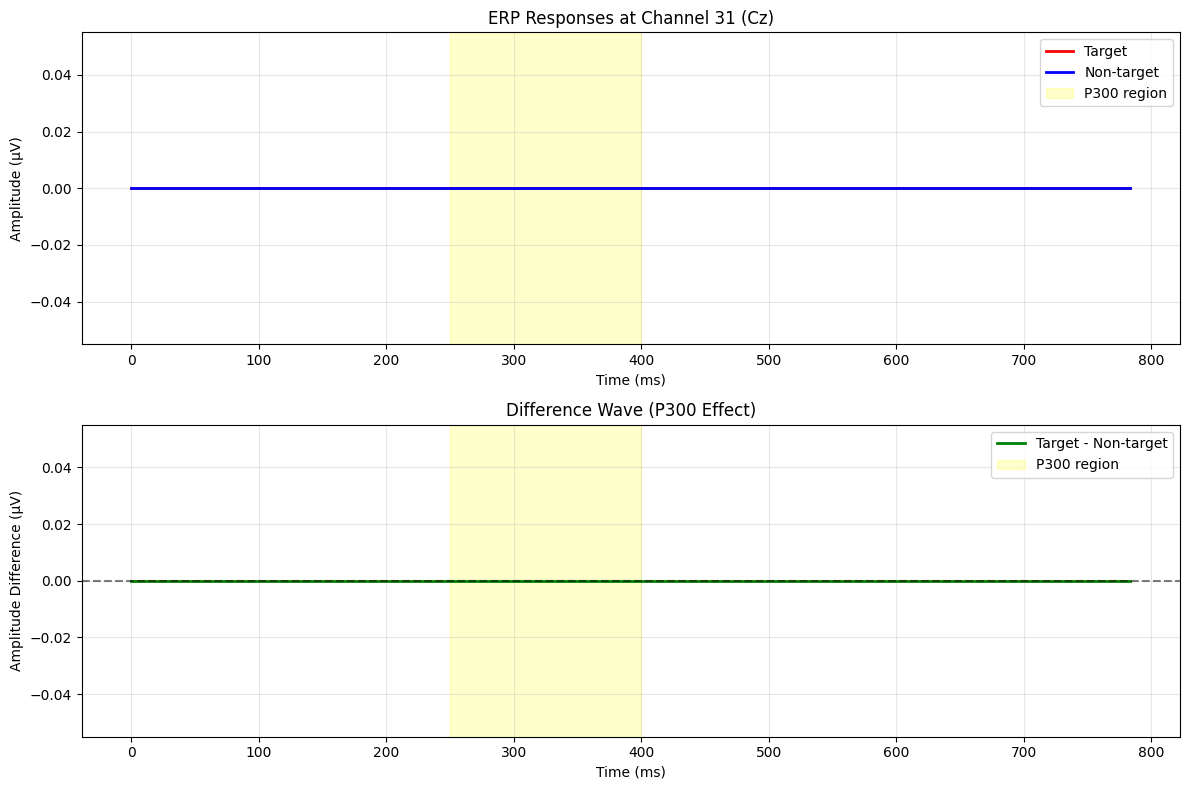

  P300 amplitude in 250-400ms window: 0.00 μV


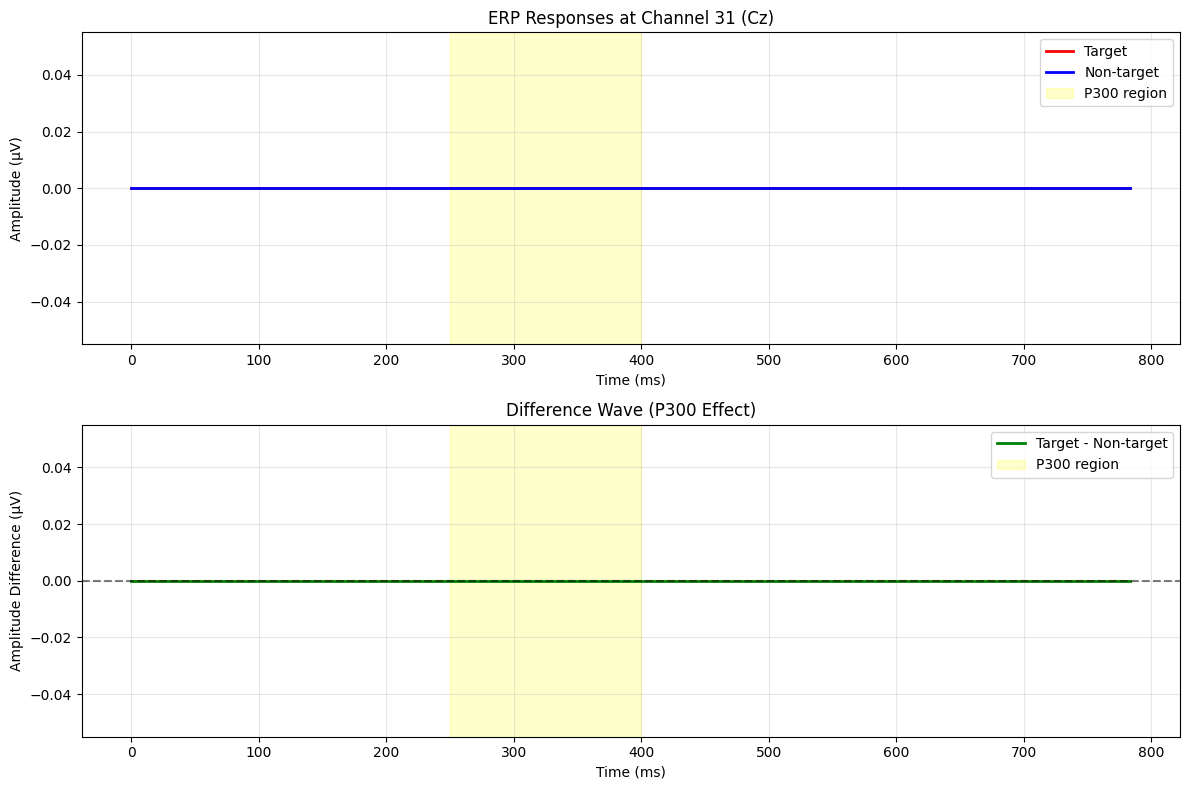

In [9]:
    # ========================================================================
    # STEP 4: VISUALIZE ERP
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 4: VISUALIZING ERP RESPONSES")
    print("="*70)

    print("\n--- Subject A ---")
    plot_erp_responses(train_epochs_A, channel_idx=31)

In [10]:
    # ========================================================================
    # STEP 5: FEATURE EXTRACTION
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 5: FEATURE EXTRACTION")
    print("="*70)

    # ========================================================================
    # Subject A: Compare PCA vs CSP vs Time-Domain
    # ========================================================================
    print("\n--- Subject A: Feature Comparison ---")

    # Enhanced NaN handling function
    def handle_nan_values(data_array, replace_with='zero'):
        """Check for NaN values and handle them robustly"""
        if np.isnan(data_array).any():
            nan_count = np.isnan(data_array).sum()
            total_elements = data_array.size
            nan_percentage = (nan_count / total_elements) * 100

            print(f"  Found {nan_count} NaN values ({nan_percentage:.2f}%)")

            if replace_with == 'zero':
                # Simple zero replacement - most robust for EEG
                data_array = np.nan_to_num(data_array, nan=0.0)
                print("  NaN values replaced with zeros")
            elif replace_with == 'mean':
                # Replace NaN with mean of the feature (column-wise)
                col_mean = np.nanmean(data_array, axis=0)
                nan_mask = np.isnan(data_array)

                # Ensure we don't have all NaN columns
                valid_columns = ~np.isnan(col_mean)
                if not np.all(valid_columns):
                    print(f"  Warning: {np.sum(~valid_columns)} columns are all NaN. Replacing with 0.")
                    col_mean[~valid_columns] = 0

                # Replace NaN values
                for col_idx in range(data_array.shape[1]):
                    nan_col_mask = nan_mask[:, col_idx]
                    if np.any(nan_col_mask):
                        data_array[nan_col_mask, col_idx] = col_mean[col_idx]
                print("  NaN values replaced with column means")
            elif replace_with == 'drop':
                # Drop rows with NaN
                data_array = data_array[~np.isnan(data_array).any(axis=1)]
                print(f"  Dropped rows with NaN. New shape: {data_array.shape}")

        return data_array

    # Enhanced data cleaning
    print("  Checking and cleaning data...")
    train_epochs_flat = train_epochs_A['epochs'].reshape(
        train_epochs_A['epochs'].shape[0], -1
    )
    train_epochs_flat = handle_nan_values(train_epochs_flat, replace_with='zero')

    # Check for constant columns and add small noise
    std_dev = np.std(train_epochs_flat, axis=0)
    if np.any(std_dev < 1e-10):
        print(f"  Adding small noise to constant features")
        noise = np.random.normal(0, 1e-6, train_epochs_flat.shape)
        train_epochs_flat = train_epochs_flat + noise

    train_epochs_clean = train_epochs_flat.reshape(train_epochs_A['epochs'].shape)

    # Create a clean epoch dictionary
    train_epochs_clean_dict = {
        'epochs': train_epochs_clean,
        'labels': train_epochs_A['labels']
    }

    # Try PCA (20 components)
    print("\n  Trying PCA with 20 components...")
    try:
        X_pca20_A, pca20_A = extract_features(train_epochs_clean_dict, method='pca', n_components=20)
        pca20_success = True
        print(f"  PCA-20 successful: {X_pca20_A.shape}")
    except Exception as e:
        print(f"  PCA-20 failed: {e}")
        print("  Using time-domain features as fallback")
        X_pca20_A = extract_time_domain_features(train_epochs_clean)
        pca20_A = None
        pca20_success = False

    # Try PCA (50 components)
    print("\n  Trying PCA with 50 components...")
    try:
        X_pca50_A, pca50_A = extract_features(train_epochs_clean_dict, method='pca', n_components=50)
        pca50_success = True
        print(f"  PCA-50 successful: {X_pca50_A.shape}")
    except Exception as e:
        print(f"  PCA-50 failed: {e}")
        X_pca50_A = X_pca20_A.copy() if pca20_success else extract_time_domain_features(train_epochs_clean)
        pca50_A = None
        pca50_success = False

    # Try CSP
    print("\n  Trying CSP with 6 components...")
    try:
        X_csp_A, csp_A = extract_features(train_epochs_clean_dict, method='csp', n_components=6)
        csp_success = True
        print(f"  CSP successful: {X_csp_A.shape}")
    except Exception as e:
        print(f"  CSP failed: {e}")
        print("  Using PCA-20 as fallback for CSP")
        if pca20_success:
            X_csp_A = X_pca20_A.copy()
            csp_A = pca20_A
        else:
            X_csp_A = extract_time_domain_features(train_epochs_clean)
            csp_A = None
        csp_success = False

    # Try Raw Time-Domain Features
    print("\n  Extracting time-domain features...")
    X_time_A = extract_time_domain_features(train_epochs_clean)
    print(f"  Time-domain features: {X_time_A.shape}")

    # Quick comparison with BALANCED LDA
    # Start with the first successful method
    if pca20_success:
        X_train_full_A = X_pca20_A
        feature_method_A = 'pca'
        n_components_A = 20
        feature_obj_A = pca20_A
        print("  Starting with PCA-20 as baseline")
    elif pca50_success:
        X_train_full_A = X_pca50_A
        feature_method_A = 'pca'
        n_components_A = 50
        feature_obj_A = pca50_A
        print("  Starting with PCA-50 as baseline")
    elif csp_success:
        X_train_full_A = X_csp_A
        feature_method_A = 'csp'
        n_components_A = 6
        feature_obj_A = CSPTransformer(csp_A)
        print("  Starting with CSP as baseline")
    else:
        X_train_full_A = X_time_A
        feature_method_A = 'time'
        n_components_A = None
        feature_obj_A = None
        print("  Starting with time-domain features as baseline")

    # Create train/val split for comparison
    X_temp, X_val_A, y_temp, y_val_A = train_test_split(
        X_train_full_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
    )
    print(f"  Created train/val split: Train={X_temp.shape}, Val={X_val_A.shape}")

    # PCA-20 test
    if pca20_success:
        print("\n  Testing PCA-20...")
        lda_pca20 = train_lda_classifier(X_temp, y_temp)
        if lda_pca20 is not None:
            acc_pca20 = evaluate_classifier(lda_pca20, X_val_A, y_val_A, "LDA-PCA20")
            y_pred_pca20 = lda_pca20.predict(X_val_A)
            f1_pca20 = f1_score(y_val_A, y_pred_pca20, zero_division=0)
        else:
            acc_pca20 = 0
            f1_pca20 = 0
    else:
        acc_pca20 = 0
        f1_pca20 = 0

    # PCA-50 test
    if pca50_success:
        print("\n  Testing PCA-50...")
        X_temp50, X_val50_A = train_test_split(
            X_pca50_A, test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
        )
        lda_pca50 = train_lda_classifier(X_temp50, y_temp)
        if lda_pca50 is not None:
            acc_pca50 = evaluate_classifier(lda_pca50, X_val50_A, y_val_A, "LDA-PCA50")
            y_pred_pca50 = lda_pca50.predict(X_val50_A)
            f1_pca50 = f1_score(y_val_A, y_pred_pca50, zero_division=0)
        else:
            acc_pca50 = 0
            f1_pca50 = 0
    else:
        acc_pca50 = 0
        f1_pca50 = 0

    # CSP test
    if csp_success:
        print("\n  Testing CSP...")
        X_temp_csp, X_val_csp_A = train_test_split(
            X_csp_A, test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
        )
        lda_csp = train_lda_classifier(X_temp_csp, y_temp)
        if lda_csp is not None:
            acc_csp = evaluate_classifier(lda_csp, X_val_csp_A, y_val_A, "LDA-CSP")
            y_pred_csp = lda_csp.predict(X_val_csp_A)
            f1_csp = f1_score(y_val_A, y_pred_csp, zero_division=0)
        else:
            acc_csp = 0
            f1_csp = 0
    else:
        acc_csp = 0
        f1_csp = 0

    # Time-Domain test
    print("\n  Testing Time-Domain features...")
    X_temp_time, X_val_time_A = train_test_split(
        X_time_A, test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
    )
    lda_time = train_lda_classifier(X_temp_time, y_temp)
    if lda_time is not None:
        acc_time = evaluate_classifier(lda_time, X_val_time_A, y_val_A, "LDA-Time")
        y_pred_time = lda_time.predict(X_val_time_A)
        f1_time = f1_score(y_val_A, y_pred_time, zero_division=0)
    else:
        acc_time = 0
        f1_time = 0

    # Ensure we have valid F1 scores
    if f1_pca20 is None or np.isnan(f1_pca20):
        f1_pca20 = 0
    if f1_pca50 is None or np.isnan(f1_pca50):
        f1_pca50 = 0
    if f1_csp is None or np.isnan(f1_csp):
        f1_csp = 0
    if f1_time is None or np.isnan(f1_time):
        f1_time = 0

    print("\n" + "="*70)
    print("FEATURE COMPARISON (Balanced Classifiers)")
    print("="*70)
    print(f"PCA (20 comp):      Accuracy={acc_pca20:.4f}, F1={f1_pca20:.4f}")
    print(f"PCA (50 comp):      Accuracy={acc_pca50:.4f}, F1={f1_pca50:.4f}")
    print(f"CSP (6 comp):       Accuracy={acc_csp:.4f}, F1={f1_csp:.4f}")
    print(f"Time-Domain (3072): Accuracy={acc_time:.4f}, F1={f1_time:.4f}")

    # Select best method based on F1-score (only consider successful methods)
    methods = {}
    if pca20_success and f1_pca20 > 0:
        methods['pca20'] = f1_pca20
    if pca50_success and f1_pca50 > 0:
        methods['pca50'] = f1_pca50
    if csp_success and f1_csp > 0:
        methods['csp'] = f1_csp
    if f1_time > 0:  # Time-domain always available
        methods['time'] = f1_time

    if methods:
        best_method = max(methods, key=methods.get)
        print(f"\n  Best feature method: {best_method.upper()} (F1={methods[best_method]:.4f})")
    else:
        best_method = 'time'
        print(f"\n  All methods failed, defaulting to time-domain features")

    # Update based on best method
    if best_method == 'pca20' and pca20_success:
        X_train_full_A = X_pca20_A
        feature_method_A = 'pca'
        n_components_A = 20
        feature_obj_A = pca20_A
    elif best_method == 'pca50' and pca50_success:
        X_train_full_A = X_pca50_A
        feature_method_A = 'pca'
        n_components_A = 50
        feature_obj_A = pca50_A
    elif best_method == 'csp' and csp_success:
        X_train_full_A = X_csp_A
        feature_method_A = 'csp'
        n_components_A = 6
        feature_obj_A = CSPTransformer(csp_A)
    else:  # time or fallback
        X_train_full_A = X_time_A
        feature_method_A = 'time'
        n_components_A = None
        feature_obj_A = None

    # ========================================================================
    # Subject A: Create final train/val split for later steps
    # ========================================================================
    X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(
        X_train_full_A, train_epochs_A['labels'], test_size=0.2, random_state=42, stratify=train_epochs_A['labels']
    )
    print(f"\nSubject A splits: Training={len(X_train_A)}, Validation={len(X_val_A)}")

    # Transform test data (with NaN handling)
    print("\n  Processing test data for Subject A...")
    test_epochs_flat = test_epochs_A['epochs'].reshape(
        test_epochs_A['epochs'].shape[0], -1
    )
    test_epochs_flat = handle_nan_values(test_epochs_flat, replace_with='zero')

    if feature_method_A == 'time':
        X_test_A = test_epochs_flat
    elif feature_method_A == 'pca' and feature_obj_A is not None:
        # Clean test data before transformation
        test_epochs_flat = np.nan_to_num(test_epochs_flat, nan=0.0)
        X_test_A = feature_obj_A.transform(test_epochs_flat)
    elif feature_method_A == 'csp' and feature_obj_A is not None:
        # Reshape for CSP
        test_epochs_reshaped = test_epochs_flat.reshape(test_epochs_A['epochs'].shape)
        test_epochs_reshaped = np.nan_to_num(test_epochs_reshaped, nan=0.0)
        X_test_A = feature_obj_A.transform(test_epochs_reshaped)
    else:
        X_test_A = test_epochs_flat

    print(f"Test features: {X_test_A.shape}")

    # ========================================================================
    # Subject B: Use same method as Subject A
    # ========================================================================
    print("\n--- Subject B: Feature Extraction ---")
    print(f"\nUsing {feature_method_A.upper()} (same as Subject A)...")

    # Prepare Subject B data with NaN handling
    print("  Checking and cleaning Subject B data...")
    train_epochs_B_flat = train_epochs_B['epochs'].reshape(
        train_epochs_B['epochs'].shape[0], -1
    )
    train_epochs_B_flat = handle_nan_values(train_epochs_B_flat, replace_with='zero')

    test_epochs_B_flat = test_epochs_B['epochs'].reshape(
        test_epochs_B['epochs'].shape[0], -1
    )
    test_epochs_B_flat = handle_nan_values(test_epochs_B_flat, replace_with='zero')

    # Add small noise if needed
    std_dev_B = np.std(train_epochs_B_flat, axis=0)
    if np.any(std_dev_B < 1e-10):
        noise = np.random.normal(0, 1e-6, train_epochs_B_flat.shape)
        train_epochs_B_flat = train_epochs_B_flat + noise

    if feature_method_A == 'time':
        X_train_full_B = train_epochs_B_flat
        X_test_B = test_epochs_B_flat
        pca_B = None
        csp_B = None
        print("  Using time-domain features for Subject B")
    elif feature_method_A == 'pca':
        # Create clean dictionary for Subject B
        train_epochs_B_clean = train_epochs_B_flat.reshape(train_epochs_B['epochs'].shape)
        train_epochs_B_clean_dict = {
            'epochs': train_epochs_B_clean,
            'labels': train_epochs_B['labels']
        }

        try:
            print(f"  Extracting PCA features with {n_components_A} components...")
            X_train_full_B, pca_B = extract_features(train_epochs_B_clean_dict, method='pca', n_components=n_components_A)
            test_epochs_B_flat = np.nan_to_num(test_epochs_B_flat, nan=0.0)
            X_test_B = pca_B.transform(test_epochs_B_flat)
            print(f"  PCA successful for Subject B: {X_train_full_B.shape}")
        except Exception as e:
            print(f"  PCA failed for Subject B: {e}")
            print("  Falling back to time-domain features for Subject B")
            X_train_full_B = train_epochs_B_flat
            X_test_B = test_epochs_B_flat
            pca_B = None
    else:  # CSP
        train_epochs_B_clean = train_epochs_B_flat.reshape(train_epochs_B['epochs'].shape)
        train_epochs_B_clean_dict = {
            'epochs': train_epochs_B_clean,
            'labels': train_epochs_B['labels']
        }

        try:
            print(f"  Extracting CSP features with {n_components_A} components...")
            X_train_full_B, csp_B = extract_features(train_epochs_B_clean_dict, method='csp', n_components=n_components_A)
            test_epochs_B_reshaped = test_epochs_B_flat.reshape(test_epochs_B['epochs'].shape)
            test_epochs_B_reshaped = np.nan_to_num(test_epochs_B_reshaped, nan=0.0)
            X_test_B = CSPTransformer(csp_B).transform(test_epochs_B_reshaped)
            print(f"  CSP successful for Subject B: {X_train_full_B.shape}")
        except Exception as e:
            print(f"  CSP failed for Subject B: {e}")
            print("  Falling back to time-domain features for Subject B")
            X_train_full_B = train_epochs_B_flat
            X_test_B = test_epochs_B_flat
            csp_B = None

    X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(
        X_train_full_B, train_epochs_B['labels'], test_size=0.2, random_state=42, stratify=train_epochs_B['labels']
    )
    print(f"Subject B splits: Training={len(X_train_B)}, Validation={len(X_val_B)}, Test features: {X_test_B.shape}")

    # Store feature objects for later use
    feature_objects = {
        'A': feature_obj_A,
        'B': pca_B if feature_method_A == 'pca' else (csp_B if feature_method_A == 'csp' else None)
    }


STEP 5: FEATURE EXTRACTION

--- Subject A: Feature Comparison ---
  Checking and cleaning data...
  Adding small noise to constant features

  Trying PCA with 20 components...
  Extracting features using PCA...
  PCA features: (15299, 20)
  Explained variance: 0.013
  PCA-20 successful: (15299, 20)

  Trying PCA with 50 components...
  Extracting features using PCA...
  PCA features: (15299, 50)
  Explained variance: 0.031
  PCA-50 successful: (15299, 50)

  Trying CSP with 6 components...
  Extracting features using CSP...
  Target epochs for CSP: 2550
  Non-target epochs for CSP: 12749
  CSP features: (15299, 6)
  CSP successful: (15299, 6)

  Extracting time-domain features...
  Time-domain features: (15299, 3072)
  Time-domain features: (15299, 3072)
  Starting with PCA-20 as baseline
  Created train/val split: Train=(12239, 20), Val=(3060, 20)

  Testing PCA-20...
  Training LDA classifier...
    Training accuracy: 0.1667

  LDA-PCA20 Performance:
    Accuracy:  0.1667
    Precis

In [11]:
    # ========================================================================
    # STEP 6: BASELINE CLASSIFIERS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 6: BASELINE CLASSIFIERS (Subject A)")
    print("="*70)

    lda_A = train_lda_classifier(X_train_A, y_train_A)
    acc_lda = evaluate_classifier(lda_A, X_val_A, y_val_A, "LDA")

    lr_A = train_logistic_regression(X_train_A, y_train_A)
    acc_lr = evaluate_classifier(lr_A, X_val_A, y_val_A, "Logistic Regression")



STEP 6: BASELINE CLASSIFIERS (Subject A)
  Training LDA classifier...
    Training accuracy: 0.1695

  LDA Performance:
    Accuracy:  0.1693
    Precision: 0.1671
    Recall:    1.0000
    F1-score:  0.2864
    Confusion Matrix:
      [[TN   8  FP 2542]]
       [FN   0  TP 510]]
    ROC-AUC:   0.6252
  Training Logistic Regression...
    Training accuracy: 0.6063

  Logistic Regression Performance:
    Accuracy:  0.5886
    Precision: 0.2248
    Recall:    0.6000
    F1-score:  0.3271
    Confusion Matrix:
      [[TN 1495  FP 1055]]
       [FN 204  TP 306]]
    ROC-AUC:   0.6252


In [12]:
# ========================================================================
# STEP 7: CLASSICAL ML MODELS
# ========================================================================
print("\n" + "="*70)
print("STEP 7: CLASSICAL MACHINE LEARNING (Subject A)")
print("="*70)

results_classical_A, models_A = compare_all_classical_models(
    X_train_A, y_train_A, X_val_A, y_val_A
)

print("\n--- Training Final SVM Models ---")
svm_A, scaler_A = train_svm_classifier(X_train_A, y_train_A)
print("  Evaluating on validation set...")
evaluate_classifier(svm_A, scaler_A.transform(X_val_A), y_val_A, "SVM-A")

svm_B, scaler_B = train_svm_classifier(X_train_B, y_train_B)
print("  Evaluating on validation set...")
evaluate_classifier(svm_B, scaler_B.transform(X_val_B), y_val_B, "SVM-B")


STEP 7: CLASSICAL MACHINE LEARNING (Subject A)
  Comparing classical ML models...

  --- Training LDA ---
    Accuracy: 0.8330, F1: 0.0000
    Training time: 0.01s, Inference time: 0.0003s

  --- Training Logistic Regression ---
    Accuracy: 0.5869, F1: 0.3255
    Training time: 0.03s, Inference time: 0.0003s

  --- Training SVM ---
    Accuracy: 0.6082, F1: 0.3160
    Training time: 38.22s, Inference time: 1.2371s

  --- Training Random Forest ---
    Accuracy: 0.8310, F1: 0.0077
    Training time: 3.94s, Inference time: 0.0556s

  --- Training Gradient Boosting ---
    Accuracy: 0.6085, F1: 0.3059
    Training time: 4.70s, Inference time: 0.0063s

MODEL COMPARISON SUMMARY
Model                Accuracy   F1-Score   Train Time   Inf Time  
----------------------------------------------------------------------
LDA                  0.8330     0.0000     0.01         0.0003    
Logistic Regression  0.5869     0.3255     0.03         0.0003    
SVM                  0.6082     0.3160     

0.607516339869281

In [13]:
    # ========================================================================
    # STEP 8: EXPORT MODELS
    # ========================================================================
    print("\n" + "="*70)
    print("STEP 8: EXPORTING MODELS")
    print("="*70)

    import os
    os.makedirs('models', exist_ok=True)

    # Save pickle
    save_model({
        'model': svm_A,
        'scaler': scaler_A,
        'feature_transformer': feature_objects['A'] # Use the stored feature transformer for Subject A
    }, 'models/subject_A_svm.pkl')

    save_model({
        'model': svm_B,
        'scaler': scaler_B,
        'feature_transformer': feature_objects['B'] # Use the stored feature transformer for Subject B
    }, 'models/subject_B_svm.pkl')


STEP 8: EXPORTING MODELS

  Model saved to: models/subject_A_svm.pkl

  Model saved to: models/subject_B_svm.pkl
